# Unit conversion with broadband detectors looking at the CMB
- categories: [cmbs4, pysm, simonsobs]

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from pysm3 import units as u
import pysm3 as pysm
%matplotlib inline

In [2]:
dip = hp.synfast([0,1], lmax=1, nside=128) * u.V

/home/zonca/zonca/p/software/healpy/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/home/zonca/zonca/p/software/healpy/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/zonca/zonca/p/software/healpy/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


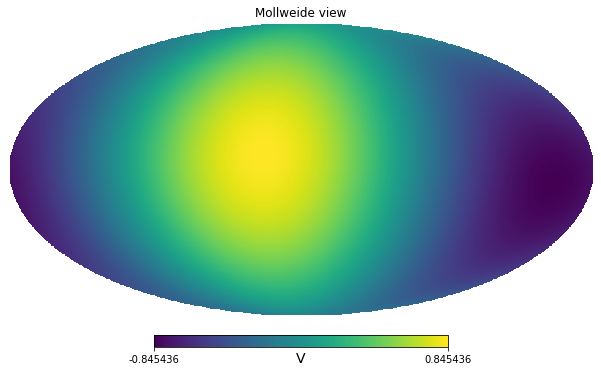

In [3]:
hp.mollview(dip, unit=dip.unit)

We measure the sky with out broadband instrument, we assume we only measure the CMB solar dipole,
initially the units are arbitrary, for example Volts of our instrument.

Next we calibrate on the solar dipole, which is known to be 3.3 mK.

In [4]:
calibration_factor = 2 * 3.3 * u.mK_CMB / (dip.max() - dip.min())

In [5]:
calibration_factor

<Quantity 3.9033114 mK_CMB / V>

In [6]:
calibrated_dip = calibration_factor * dip

In [7]:
calibrated_dip

<Quantity [ 0.44224864,  0.41525913,  0.40329058, ..., -0.43028009,
           -0.44224864, -0.41525913] mK_CMB>

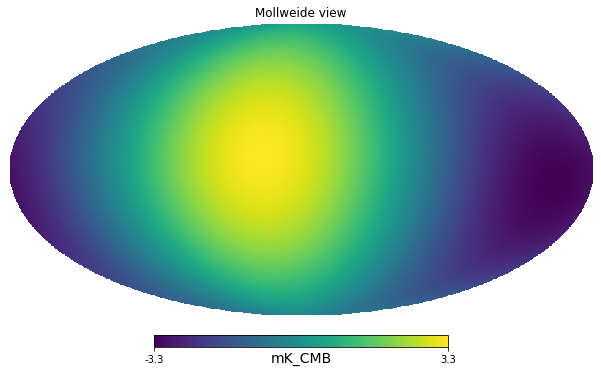

In [8]:
hp.mollview(calibrated_dip, unit=calibrated_dip.unit)

First we simplify and consider a delta-frequency instrument at 300 GHz

In [9]:
center_frequency = 300 * u.GHz

In [10]:
dip_peak = calibrated_dip.max()

In [11]:
calibrated_dip.max()

<Quantity 3.3 mK_CMB>

In [12]:
calibrated_dip.max().to(u.mK_RJ, equivalencies=u.cmb_equivalencies(center_frequency))

<Quantity 0.47252855 mK_RJ>

In [13]:
calibrated_dip.max().to(u.MJy/u.sr, equivalencies=u.cmb_equivalencies(center_frequency))

<Quantity 1.30659935 MJy / sr>

Next we assume instead that we have a broadband instrument, of 20% bandwidth, with uniform response in that range.
For simplicity, we only take 4 points.

In [14]:
freq = [270, 290, 310, 330] * u.GHz

In [15]:
weights = [1, 1, 1, 1]

In [16]:
weights /= np.trapz(weights, freq)

In [17]:
weights

<Quantity [0.01666667, 0.01666667, 0.01666667, 0.01666667] 1 / GHz>

The instrument bandpass is defined in power so we can transform our signal in MJy/sr at the 4 reference frequencies,
then integrate.

In [18]:
dip_peak_MJysr = dip_peak.to(u.MJy/u.sr, equivalencies=u.cmb_equivalencies(freq))

In [19]:
dip_peak_MJysr

<Quantity [1.46428149, 1.36325498, 1.24713961, 1.12324616] MJy / sr>

In [20]:
integrated_SR = np.trapz(dip_peak_MJysr * weights, freq)

In [21]:
integrated_SR

<Quantity 1.30138614 MJy / sr>

This is different than assuming uniform bandpass in $K_{CMB}$, where instead we would recover the same result of the delta-bandpass:

In [22]:
np.trapz(dip_peak * weights, freq)

<Quantity 3.3 mK_CMB>

In [23]:
SR = u.MJy/u.sr

We use the PySM 3 function to compute unit conversion given a bandpass

$ \tilde{I}[unit_{out}] = \tilde{I}[unit_{in}] \dfrac{ \int C_{unit_{in}}^{Jy~sr^{-1}}(\nu) g(\nu) d\nu}  { \int C_{unit_{out}}^{Jy~sr^{-1}}(\nu) g(\nu) d\nu} $

which comes from equating in power:

$ \tilde{I}[unit_{out}]{ \int C_{unit_{out}}^{Jy~sr^{-1}}(\nu) g(\nu) d\nu} = \tilde{I}[unit_{in}]\int C_{unit_{in}}^{Jy~sr^{-1}}(\nu) g(\nu) d\nu   $

In [24]:
SR

Unit("MJy / sr")

In [25]:
pysm.utils.bandpass_unit_conversion(freq, weights=weights, output_unit=u.mK_CMB, input_unit=SR)

<Quantity 2.53575776 mK_CMB sr / MJy>

In [26]:
integrated_SR * _

<Quantity 3.3 mK_CMB>

In [27]:
1 * u.mK_CMB / (1 * SR)

<Quantity 1. mK_CMB sr / MJy>

We can doublecheck the implementation of the PySM function by executing it here:

In [28]:
K_CMB_to_MJysr = ((1*SR).to(u.mK_CMB, equivalencies=u.cmb_equivalencies(freq)))/(1*SR)

In [29]:
K_CMB_to_MJysr

<Quantity [2.25366503, 2.42067702, 2.646055  , 2.93791344] mK_CMB sr / MJy>

Integrating the `K_CMB_to_MJysr` conversion factor is wrong, we always need to do the integral in power,
therefore we integrate the inverse and then take its inverse.

In [30]:
np.trapz(K_CMB_to_MJysr * weights, freq)

<Quantity 2.55417375 mK_CMB sr / MJy>

In [31]:
1/np.trapz(1/K_CMB_to_MJysr * weights, freq)

<Quantity 2.53575776 mK_CMB sr / MJy>